# Modeling
Filename: model

In [40]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pyspark.sql.functions import when, col, lower, upper, round, regexp_extract, count, countDistinct
from pyspark.sql.types import DoubleType

import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from pyspark.sql import SparkSession, DataFrame, Column, Row, GroupedData, \
    DataFrameNaFunctions, DataFrameStatFunctions, functions, types, Window
from pyspark.sql.functions import col, expr
from pyspark.sql import functions as f
import pyspark.sql.types as T
from pyspark.sql.functions import round
from pyspark.sql.functions import format_string
from pyspark.sql.functions import trim, upper
from pyspark.sql.functions import substring
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import sum, sumDistinct
import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import count, countDistinct, approx_count_distinct
from pyspark.sql.functions import mean, stddev, variance, skewness, kurtosis
from pyspark.sql.functions import when, col, lower, upper, round, regexp_extract, count, countDistinct
from pyspark.sql.types import DoubleType
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import SQLTransformer

In [2]:
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("classification") \
                    .getOrCreate()

In [3]:
case_data = "sa311/case.csv"
case_df = spark.read.csv(case_data, header=True)

dept_data = "sa311/dept.csv"
dept_df = spark.read.csv(dept_data, header=True)

In [4]:
df = case_df.join(dept_df, "dept_division", "left_outer")

In [5]:
df.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- case_id: string (nullable = true)
 |-- case_opened_date: string (nullable = true)
 |-- case_closed_date: string (nullable = true)
 |-- SLA_due_date: string (nullable = true)
 |-- case_late: string (nullable = true)
 |-- num_days_late: string (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: string (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: string (nullable = true)



In [6]:
# Convert the date fields to be of data type timestamp.
df = df.withColumn("case_opened_date", 
                   f.to_timestamp(f.col("case_opened_date"), 
                                  "M/d/yy H:mm")) \
       .withColumn("case_closed_date", 
                   f.to_timestamp(f.col("case_closed_date"),
                                  "M/d/yy H:mm")) \
       .withColumn("SLA_due_date", 
                   f.to_timestamp(f.col("SLA_due_date"),
                                  "M/d/yy H:mm")) \
       .withColumn("case_late", 
                   f.when(df.case_late == "YES", True) \
                    .otherwise(False)) \
       .withColumn("case_closed", f.when(df.case_closed == "YES", True) \
                    .otherwise(False))

In [7]:
# Compute the number of days past the SLA due date.
# --Spark
# DATEDIFF ( enddate , startdate )

df = df.withColumn("days_past_SLA", 
                   f.datediff(f.current_timestamp(), 
                              "SLA_due_date"))

In [8]:
# Compute the number of days since opened.
# --Spark
# DATEDIFF ( enddate , startdate )

df = df.withColumn("days_since_opening", 
                   f.datediff(f.current_timestamp(), 
                              "case_opened_date"))

In [9]:
# Extract the year from the case_closed_date column.

df = df.withColumn("year_closed", 
              year("case_closed_date"))

In [10]:
df.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- case_id: string (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- SLA_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = false)
 |-- num_days_late: string (nullable = true)
 |-- case_closed: boolean (nullable = false)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: string (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: string (nullable = true)
 |-- days_past_SLA: integer (nullable = true)
 |-- days_since_opening: integer (nullable = true)
 |-- year_closed: integer (nullable = true)



In [11]:
df.show(1, vertical=True, truncate=False, )

-RECORD 0------------------------------------------------------
 dept_division          | Field Operations                     
 case_id                | 1014127332                           
 case_opened_date       | 2018-01-01 00:42:00                  
 case_closed_date       | 2018-01-01 12:29:00                  
 SLA_due_date           | 2020-09-26 00:42:00                  
 case_late              | false                                
 num_days_late          | -998.5087616000001                   
 case_closed            | true                                 
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 source_id              | svcCRMLS                             
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 dept_name              | Animal Care Se

Are there any features that are drivers of a case being late? Consider:
- department
- type of department
- location of request
- council district

In [13]:
df = df.select(lower(col('dept_division')).alias('dept_division'), 
          lower(col('service_request_type')).alias('request_type'),
          lower(col('dept_name')).alias('dept_name'),
          lower(col('standardized_dept_name')).alias('dept_name_std'),
          (col('case_closed')=='YES').alias('case_closed'),
          when(col('case_late')=='YES', 1).otherwise(0).alias('target'),
          (col('dept_subject_to_SLA')=='YES').alias('dept_w_SLA'),
          round(col('num_days_late').cast(DoubleType()), 2).alias('days_late'),
          round(col('SLA_days').cast(DoubleType()), 2).alias('SLA_days'),
          regexp_extract(col('request_address'),"(\d{5})$", 1).\
               alias("request_address_zip"),
          (col('council_district').cast(IntegerType()))
         )

Examine the contents of dept_division, dept_name, and dept_name_std to see which to keep and see how many distinct request types there are.

In [17]:
df.select(countDistinct('dept_division'), 
          countDistinct('dept_name'),
          countDistinct('dept_name_std'),
          countDistinct('request_type')).\
          toPandas().transpose()

,0
count(DISTINCT dept_division),39
count(DISTINCT dept_name),9
count(DISTINCT dept_name_std),8
count(DISTINCT request_type),334


In [26]:
df.select('dept_division',
          'dept_name',
          'dept_name_std').distinct() \
  .show(50, truncate=False)

+-----------------------------+-------------------------+------------------------+
|dept_division                |dept_name                |dept_name_std           |
+-----------------------------+-------------------------+------------------------+
|district 9                   |city council             |city council            |
|clean and green              |parks and recreation     |parks & recreation      |
|graffiti (intexp)            |code enforcement services|dsd/code enforcement    |
|dangerous premise (intexp)   |code enforcement services|dsd/code enforcement    |
|311 call center              |customer service         |customer service        |
|storm water                  |trans & cap improvements |trans & cap improvements|
|shops                        |parks and recreation     |parks & recreation      |
|district 2                   |city council             |city council            |
|food establishments          |metro health             |metro health            |
|dir

dept_name is null for internal code enforcement, so we should change that value. But first, let's make a list of each field's values.

In [27]:
df.select('dept_division').distinct() \
  .show(50, truncate=False)

+-----------------------------+
|dept_division                |
+-----------------------------+
|code enforcement             |
|storm water engineering      |
|district 6                   |
|shops (internal)             |
|graffiti (intexp)            |
|graffiti                     |
|code enforcement (internal)  |
|district 10                  |
|food establishments          |
|traffic engineering design   |
|trades                       |
|district 7                   |
|district 9                   |
|brush                        |
|district 8                   |
|engineering division         |
|district 3                   |
|streets                      |
|dangerous premise (intexp)   |
|shops                        |
|clean and green              |
|dangerous premise            |
|waste collection             |
|signals                      |
|field operations             |
|storm water                  |
|311 call center              |
|code enforcement (intexp)    |
|directo

In [24]:
df.select('dept_name').distinct().show(50, truncate=False)
# Remember that the null value is used for internal code enforcement cases.

+-------------------------+
|dept_name                |
+-------------------------+
|metro health             |
|city council             |
|animal care services     |
|null                     |
|solid waste management   |
|code enforcement services|
|parks and recreation     |
|customer service         |
|trans & cap improvements |
|development services     |
+-------------------------+



In [25]:
df.select('dept_name_std').distinct().show(50, truncate=False)
# This one does not have null,
# shortened solid waste management to solid waste,
# and appears to have combined 
# code enforcement services and development services.

+------------------------+
|dept_name_std           |
+------------------------+
|metro health            |
|city council            |
|animal care services    |
|dsd/code enforcement    |
|parks & recreation      |
|customer service        |
|trans & cap improvements|
|solid waste             |
+------------------------+



Drop dept_name_std.

In [28]:
df = df.drop('dept_name_std')

Fill the null fields with internal code enforcement.

In [29]:
df = df.na.fill({"dept_name": "internal code enforcement"})

Now let's see what we have.

In [30]:
df.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- request_type: string (nullable = true)
 |-- dept_name: string (nullable = false)
 |-- case_closed: boolean (nullable = true)
 |-- target: integer (nullable = false)
 |-- dept_w_SLA: boolean (nullable = true)
 |-- days_late: double (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- request_address_zip: string (nullable = true)
 |-- council_district: integer (nullable = true)



In [31]:
df.show(1, vertical=True, truncate=False, )

-RECORD 0-----------------------------------
 dept_division       | field operations     
 request_type        | stray animal         
 dept_name           | animal care services 
 case_closed         | true                 
 target              | 0                    
 dept_w_SLA          | true                 
 days_late           | -998.51              
 SLA_days            | 999.0                
 request_address_zip | 78207                
 council_district    | 5                    
only showing top 1 row



Filter out the closed cases since we only wish to examine those that are still open.

In [33]:
# __THIS__ is a placeholder for the DataFrame 
# passed into the transform method.
filterer = SQLTransformer(
    statement="SELECT * FROM __THIS__ WHERE \
           dept_w_SLA AND case_closed")

filtered = filterer.transform(df)

In [34]:
filtered.\
    groupBy('target').\
    count().orderBy('target').show()

+------+------+
|target| count|
+------+------+
|     0|735612|
|     1| 87978|
+------+------+



In [35]:
filtered.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- request_type: string (nullable = true)
 |-- dept_name: string (nullable = false)
 |-- case_closed: boolean (nullable = true)
 |-- target: integer (nullable = false)
 |-- dept_w_SLA: boolean (nullable = true)
 |-- days_late: double (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- request_address_zip: string (nullable = true)
 |-- council_district: integer (nullable = true)



#### Extract, transform, and select features
Create function to explore features:

In [36]:
def explore(df, target, cont1, cont2):
    from pyspark.sql.functions import count, mean, corr
    aggregated = df.groupby(target).agg(count(cont1), 
                                      mean(cont1),
                                      mean(cont2),
                                      corr(cont1,cont2)
                                     ).orderBy(target)
    aggregated.show()

In [37]:
explore(filtered, 'target','SLA_days','days_late')

+------+---------------+-----------------+------------------+-------------------------+
|target|count(SLA_days)|    avg(SLA_days)|    avg(days_late)|corr(SLA_days, days_late)|
+------+---------------+-----------------+------------------+-------------------------+
|     0|         735612|64.44108282626885|-58.57142732854064|      -0.9976264528231141|
|     1|          87978|14.20260667439587|22.111734751869747|      0.24758733973851244|
+------+---------------+-----------------+------------------+-------------------------+



Takeaway: the cases that are past their due date seem to have shorter SLA's

In [38]:
sample_pdf = filtered.select('SLA_days', 'days_late', 'target'). \
  sample(False, 0.20, 12345). \
  toPandas()

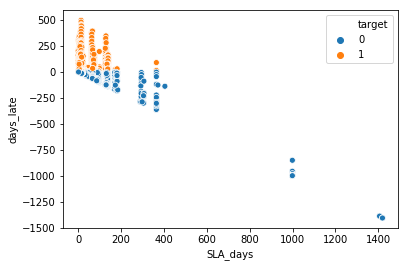

In [41]:
sns.scatterplot(x=sample_pdf.SLA_days, 
                y=sample_pdf.days_late,
                hue=sample_pdf.target
               )

plt.show()

In [43]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="dept_name", outputCol="dept_name_ix")
indexer_model = indexer.fit(filtered)
list(enumerate(indexer_model.labels))
indexed = indexer_model.transform(filtered)
indexed.select("dept_name", "dept_name_ix").show(5)

+--------------------+------------+
|           dept_name|dept_name_ix|
+--------------------+------------+
|animal care services|         2.0|
|trans & cap impro...|         3.0|
|trans & cap impro...|         3.0|
|code enforcement ...|         0.0|
|animal care services|         2.0|
+--------------------+------------+
only showing top 5 rows



Then we use OneHotEncoder to generate a set of dummy variables:

In [44]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol="dept_name_ix", outputCol="dept_name_cd")
encoded = encoder.transform(indexed)
encoded.select("dept_name", "dept_name_ix", "dept_name_cd").show(5)

+--------------------+------------+-------------+
|           dept_name|dept_name_ix| dept_name_cd|
+--------------------+------------+-------------+
|animal care services|         2.0|(8,[2],[1.0])|
|trans & cap impro...|         3.0|(8,[3],[1.0])|
|trans & cap impro...|         3.0|(8,[3],[1.0])|
|code enforcement ...|         0.0|(8,[0],[1.0])|
|animal care services|         2.0|(8,[2],[1.0])|
+--------------------+------------+-------------+
only showing top 5 rows



cat_var1_cd is stored as a SparseVector.

Now we can (manually) select our features and label:

In [45]:
selected = encoded.select("SLA_days", "dept_name_cd", "target")
features = ["SLA_days", "dept_name_cd"]

The machine learning algorithms in Spark MLlib expect the features to be collected into a single column, so we use VectorAssembler to assemble our feature vector:

In [46]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled = assembler.transform(selected)
assembled.head(5)

[Row(SLA_days=999.0, dept_name_cd=SparseVector(8, {2: 1.0}), target=0, features=SparseVector(9, {0: 999.0, 3: 1.0})),
 Row(SLA_days=4.32, dept_name_cd=SparseVector(8, {3: 1.0}), target=0, features=SparseVector(9, {0: 4.32, 4: 1.0})),
 Row(SLA_days=4.32, dept_name_cd=SparseVector(8, {3: 1.0}), target=0, features=SparseVector(9, {0: 4.32, 4: 1.0})),
 Row(SLA_days=16.29, dept_name_cd=SparseVector(8, {0: 1.0}), target=0, features=SparseVector(9, {0: 16.29, 1: 1.0})),
 Row(SLA_days=0.13, dept_name_cd=SparseVector(8, {2: 1.0}), target=1, features=SparseVector(9, {0: 0.13, 3: 1.0}))]

features is stored as a SparseVector.

Save data for subsequent modules:

In [47]:
assembled.write.parquet("sa311/assembled", mode="overwrite")

1. Use the .randomSplit method to split the 311 data into training and test sets.

#### Create train and test sets

We will fit our model on the train DataFrame and evaluate our model on the test DataFrame:

In [48]:
(train, test) = assembled.randomSplit([0.7, 0.3], 12345)

2. Create a classification model to predict whether a case will be late or not (i.e. predict case_late). Experiment with different combinations of features and different classification algorithms.

Weights must be doubles.

#### Specify a logistic regression model

Use the LogisticRegression class to specify a logistic regression model:

In [49]:
from pyspark.ml.classification import LogisticRegression
log_reg = LogisticRegression(featuresCol="features", labelCol="target")

Use the explainParams method to get a full list of hyperparameters:

In [50]:
print(log_reg.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: target)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. Th

#### Fit the logistic regression model
Use the fit method to fit the logistic regression model on the train DataFrame:

In [51]:
log_reg_model = log_reg.fit(train)

The result is an instance of the LogisticRegressionModel class:

In [52]:
type(log_reg_model)

pyspark.ml.classification.LogisticRegressionModel

#### Examine the logistic regression model
The model parameters are stored in the intercept and coefficients attributes:


In [53]:
log_reg_model.intercept
log_reg_model.coefficients

DenseVector([-0.0165, -2.0369, -2.1576, -1.2221, -2.7785, -1.4834, -1.6436, 0.1187, 2.6067])

The summary attribute is an instance of the BinaryLogisticRegressionTrainingSummary class:

In [54]:
type(log_reg_model.summary)

pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary

We can query the iteration history:

In [55]:
log_reg_model.summary.totalIterations
log_reg_model.summary.objectiveHistory

[0.3392421562440491,
 0.3315334781193492,
 0.3206644997947879,
 0.3183481101392615,
 0.31755529449485603,
 0.31712331561943446,
 0.31635776779661284,
 0.31570139507978195,
 0.3149374337733971,
 0.31418769670016844,
 0.3140280942418927,
 0.3139810232131948,
 0.3139708380378608,
 0.3139707216201347,
 0.313970685029307,
 0.31397061072198146,
 0.31397042711039175,
 0.31396994128073263,
 0.3139687238751262,
 0.3139656807749887,
 0.3139578683569557,
 0.31393967712100757,
 0.3139308257080037,
 0.3138986098916888,
 0.3138819386361396,
 0.31387784085055764,
 0.31387773180136724,
 0.3138777058007543,
 0.31387769834700435,
 0.31387767507570613,
 0.3138776728874259,
 0.3138776658752167,
 0.31387766555619145,
 0.31387766553947377,
 0.3138776655308732]

and plot it too:

In [56]:
def plot_iterations(summary):
  plt.plot(summary.objectiveHistory)
  plt.title("Training Summary")
  plt.xlabel("Iteration")
  plt.ylabel("Objective Function")
  plt.show()

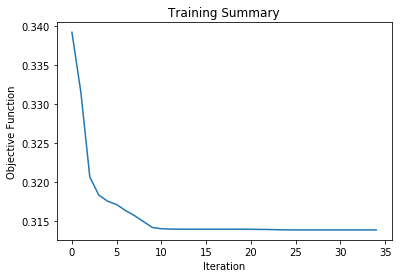

In [57]:
plot_iterations(log_reg_model.summary)

### The AUC-ROC Curve
- AUC: Area Under The Curve
- ROC: Receiver Operating Characteristics
- TPR: True Positive Rate
- FPR: False Positive Rate

##### AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. For example, the higher the AUC, the better the model is at distinguishing between patients with disease and no disease. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

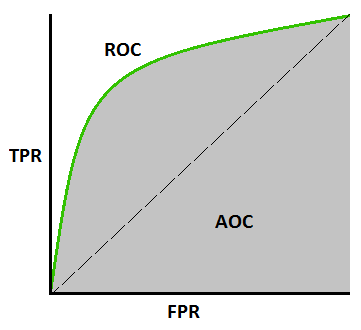

#### Understanding AUC-ROC Curve

To query the area under the ROC curve to measure the model's performance:


In [58]:
log_reg_model.summary.areaUnderROC

0.6745558810195302

and plot the ROC curve:

In [59]:
log_reg_model.summary.roc.show(5)

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|2.679944692155918...|0.003077674645823...|
|6.932900399272919E-4|0.014329913694837975|
|0.001332204390448...|0.015583781143136298|
| 0.09345433218885454| 0.27964500895619604|
+--------------------+--------------------+
only showing top 5 rows



In [60]:
def plot_roc_curve(summary):
  roc_curve = summary.roc.toPandas()
  plt.plot(roc_curve["FPR"], roc_curve["FPR"], "k")
  plt.plot(roc_curve["FPR"], roc_curve["TPR"])
  plt.title("ROC Area: %s" % summary.areaUnderROC)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()

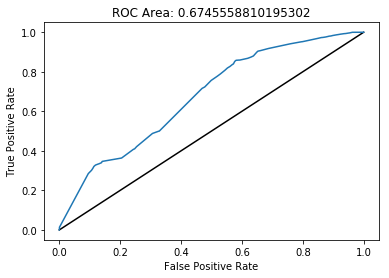

In [61]:
plot_roc_curve(log_reg_model.summary)

### Evaluate model performance on the test set.
We have been assessing the model performance on the train DataFrame. We really want to assess it on the test DataFrame.

Method 1: Use the evaluate method of the LogisticRegressionModel class

In [62]:
test_summary = log_reg_model.evaluate(test)

The result is an instance of the BinaryLogisticRegressionSummary class:

In [63]:
type(test_summary)

pyspark.ml.classification.BinaryLogisticRegressionSummary

It has attributes similar to those of the BinaryLogisticRegressionTrainingSummary class:

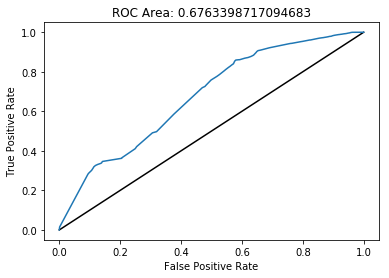

In [64]:
test_summary.areaUnderROC
plot_roc_curve(test_summary)

Method 2: Use the evaluate method of the BinaryClassificationEvaluator class.

Generate predictions on the test DataFrame:

In [66]:
test_with_prediction = log_reg_model.transform(test)
test_with_prediction.show(5)

+--------+-------------+------+--------------------+--------------------+--------------------+----------+
|SLA_days| dept_name_cd|target|            features|       rawPrediction|         probability|prediction|
+--------+-------------+------+--------------------+--------------------+--------------------+----------+
|    0.13|(8,[2],[1.0])|     0|(9,[0,3],[0.13,1.0])|[1.00711795493807...|[0.73245574973431...|       0.0|
|    0.13|(8,[2],[1.0])|     0|(9,[0,3],[0.13,1.0])|[1.00711795493807...|[0.73245574973431...|       0.0|
|    0.13|(8,[2],[1.0])|     0|(9,[0,3],[0.13,1.0])|[1.00711795493807...|[0.73245574973431...|       0.0|
|    0.13|(8,[2],[1.0])|     0|(9,[0,3],[0.13,1.0])|[1.00711795493807...|[0.73245574973431...|       0.0|
|    0.13|(8,[2],[1.0])|     0|(9,[0,3],[0.13,1.0])|[1.00711795493807...|[0.73245574973431...|       0.0|
+--------+-------------+------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



The resulting DataFrame includes three types of predictions. The rawPrediction is a vector of log-odds, prediction is a vector or probabilities prediction is the predicted class based on the probability vector.

# My understanding is the other exercises section replaced this one, so I did not do this.

# Exercises
In the exercises we add another feature to the classification model and determine if it improves the model performance.

1. Determine if request_address_zip is a promising feature.

2. Reassemble the feature vector and include request_address_zip.

3. Create new train and test datasets.

4. Refit the logistic regression model on the train dataset.

5. Apply the refit logistic model to the test dataset.

6. Compute the AUC on the test dataset.

# Cleanup
Stop the SparkSession

In [ ]:
spark.stop()